In [12]:
import numpy as np
import time
from interface import ExoSkeletonUDPInterface
import matplotlib.pyplot as plt

import imu_core.imu_core_cpp as IMU

In [2]:
imu_base = IMU.Imu3DM_GX3_45("/dev/ttyACM4", True)
imu_base.initialize()

imu_shoulder = IMU.Imu3DM_GX3_45("/dev/ttyACM2", True)
imu_shoulder.initialize()

UsbStream::read_device: Failed to read port /dev/ttyACM4. Requested 14 bytes and received 10 bytes: [ 75 65 0D 04 04 F1 03 00 E3 B6 ]


True

Warning this thread is not going to be real time.
UsbStream::read_device: Failed to read port /dev/ttyACM4. Requested 72 bytes and received 14 bytes: [ 75 65 0C 08 04 F1 11 00 04 F1 11 00 FA B5 ]
Warning this thread is not going to be real time.


In [3]:
iRb = (imu_base.get_rotation_matrix()).copy().T
print(iRb)
iRs = (imu_shoulder.get_rotation_matrix()).copy().T
print(iRs)

[[-0.66279519 -0.73654026 -0.13494825]
 [-0.74879891  0.65233707  0.117288  ]
 [ 0.00164442  0.17878702 -0.98388648]]
[[ 0.95445734 -0.29819703  0.00947584]
 [-0.29535532 -0.93992102  0.17121243]
 [-0.0421485  -0.16621372 -0.9851886 ]]


In [4]:
data_q = []
data_Rb = []
data_Rs = []
data_timestamp = []

counter = 0

interface = ExoSkeletonUDPInterface()

interface.setCommand([0.], [0.], [0.], [0.0], [0.0], [0.])

while True:
    time.sleep(0.001)
    state = interface.getState()
    iRb = (imu_base.get_rotation_matrix()).copy().T
    iRs = (imu_shoulder.get_rotation_matrix()).copy().T
    if state is not None:
        torque = 1.5 
        counter += 1
        if counter > 2000:
            data_q.append(state["q"])
            data_Rb.append(iRb)
            data_Rs.append(iRs)
            data_timestamp.append(time.time())
            
        interface.setCommand([0], [0.], [0], [0], [torque], [0.])
    else:
        print("warning - no message received")


KeyboardInterrupt: 

In [5]:
ndata_q = np.asarray(data_q)



In [13]:
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt


In [7]:
angle_mat = []
for i in range(len(data_Rb)):
    T = data_Rb[i].T @ data_Rs[i]
    angle = Rotation.from_matrix(T).as_rotvec()
    angle_mat.append(np.linalg.norm(angle))

angle_mat = np.asarray(angle_mat)

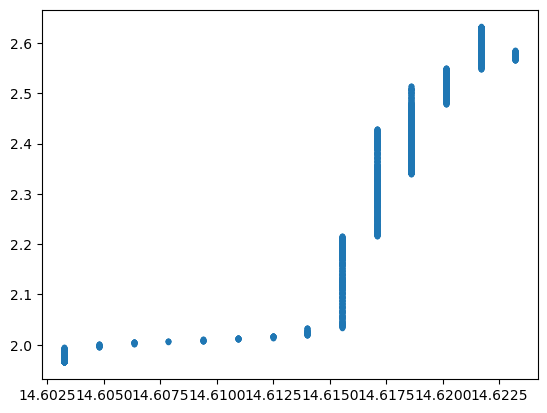

In [8]:
t_start = 0
t_end = len(data_q)
plt.plot(data_q[t_start:t_end], angle_mat[t_start:t_end],'.')

In [10]:
%matplotlib
plt.plot(angle_mat[t_start:t_end]/max(angle_mat[t_start:t_end]))
plt.plot(data_q[t_start:t_end]/max(data_q))

Using matplotlib backend: QtAgg


In [1]:
import pickle as pkl

In [4]:
with open("data/dataset1.pkl", "rb") as f:
    data = pkl.load(f)

In [10]:
data_q = np.array(data["q"]).squeeze()
data_q -= np.mean(data_q[0:500])
data_shoulder = data["shoulder_T"]
data_arm = data["arm_T"]

In [14]:
angle_mat = []
for i in range(len(data_shoulder)):
    T = np.linalg.inv(data_shoulder[i]) @ data_arm[i]
    T = T[0:3,0:3]
    angle = Rotation.from_matrix(T).as_rotvec()
    angle_mat.append(np.linalg.norm(angle))

angle_mat = np.asarray(angle_mat)

In [23]:
plt.plot(data_q, angle_mat)


In [42]:
poly_coef = np.polyfit(np.array(data_q).squeeze(), angle_mat, 15)
test = np.polyval(poly_coef, np.array(data_q).squeeze())
plt.plot(test, label="predicted")
plt.plot(angle_mat, label = "actual")
plt.legend()
plt.grid()

/tmp/ipykernel_175854/1450416813.py:1: RankWarning: Polyfit may be poorly conditioned
  poly_coef = np.polyfit(np.array(data_q).squeeze(), angle_mat, 15)


In [44]:
plt.plot(data_q, test)
plt.plot(data_q, angle_mat)

In [35]:
test.shape

(4,)